In [16]:
import pandas as pd
import numpy as np
# pygad es una librería de algoritmos genéticos (https://pygad.readthedocs.io/en/latest/pygad.html)
!pip install pygad
import pygad

In [17]:
# carga de datos YA BINARIOS.
# Requiere fichero lungcancer_binario.csv en GitHub

df = pd.read_csv('/content/mushroom_cleaned.csv')

df

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
0,1372,2,2,10,3.807467,1545,11,1.804273,1
1,1461,2,2,10,3.807467,1557,11,1.804273,1
2,1371,2,2,10,3.612496,1566,11,1.804273,1
3,1261,6,2,10,3.787572,1566,11,1.804273,1
4,1305,6,2,10,3.711971,1464,11,0.943195,1
...,...,...,...,...,...,...,...,...,...
54030,73,5,3,2,0.887740,569,12,0.943195,1
54031,82,2,3,2,1.186164,490,12,0.943195,1
54032,82,5,3,2,0.915593,584,12,0.888450,1
54033,79,2,3,2,1.034963,491,12,0.888450,1


In [18]:
def convert_to_binary(df):
    """
    Convierte los atributos de un DataFrame a binarios o one-hot,
    sin modificar los atributos que ya son binarios.

    Parámetros:
    df : pd.DataFrame
        El DataFrame a convertir.

    Retorna:
    pd.DataFrame
        Un nuevo DataFrame con las columnas convertidas a formato binario o one-hot.
    """
    df_binary = df.copy()

    for column in df_binary.columns:
        # Verifica si la columna es binaria (0/1)
        if df_binary[column].dtype in ['int64', 'float64']:
            if df_binary[column].nunique() == 2:
                df_binary[column].astype(int)  # No modificar columnas binarias
            elif df_binary[column].nunique() > 3:
                # Aplica binning y luego one-hot
                df_binned = pd.cut(df_binary[column], bins=4, labels=False)
                df_one_hot = pd.get_dummies(df_binned, prefix=column)
                df_binary = pd.concat([df_binary, df_one_hot], axis=1).astype(int)
                df_binary.drop(column, axis=1, inplace=True)
            else:
                # Aplica one-hot directamente
                df_one_hot = pd.get_dummies(df_binary[column], prefix=column)
                df_binary = pd.concat([df_binary, df_one_hot], axis=1).astype(int)
                df_binary.drop(column, axis=1, inplace=True)
        elif df_binary[column].dtype == 'object':
            # Si la columna es categórica, aplica one-hot
            df_one_hot = pd.get_dummies(df_binary[column], prefix=column)
            df_binary = pd.concat([df_binary, df_one_hot], axis=1).astype(int)
            df_binary.drop(column, axis=1, inplace=True)

    return df_binary

In [19]:
df = convert_to_binary(df)
print(df.shape)

(54035, 30)


#Train test split

In [20]:
datos = df.to_numpy()
X = datos[:,:-1]
Y = datos[:,-1]

In [21]:
print(np.unique(Y))

[0 1]


In [22]:
# separar en train y test (80%/20%)
from sklearn.model_selection import train_test_split

# Separa en train y test (80% train, 20% test)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)

print(len(Xtrain), len(Xtest))

43228 10807


# Inicializar poblacion

In [41]:
def generate_population(population_size, individuo_size):
    population = np.empty((population_size, individuo_size))
    for i in range(individuo_size):
        population[:, i] = np.random.uniform(low = 0, high = 1, size = population_size)
    population /= population.sum(axis=1, keepdims=True)
    return population.astype(np.float64)

[0.03698516 0.02593438 0.07567793 ... 0.06401203 0.05680287 0.05509207]


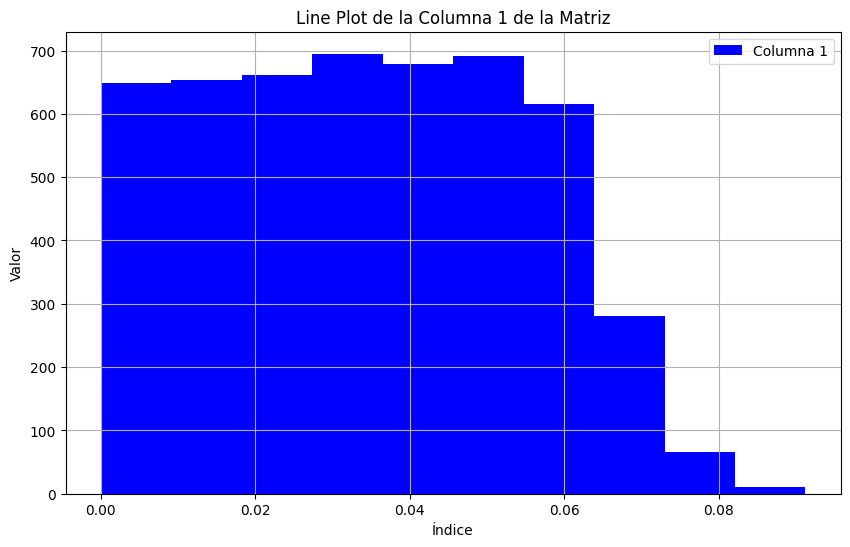

In [24]:
import matplotlib.pyplot as plt

population = generate_population(5000, X.shape[1])
columna = population[:,0]
print(population[:,0])
plt.figure(figsize=(10, 6))
plt.hist(columna, label='Columna 1', color='blue')

# Añadir etiquetas y título
plt.title('Line Plot de la Columna 1 de la Matriz')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.grid(True)
plt.legend()
plt.show()

# Función Fitness

In [67]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# función auxiliar para calcular el fitness de una población
def fitness_poblacion(poblacion, umbral = 0.5, metrica = 'f1'):

  poblacion = np.asarray(poblacion)
  probs = np.dot(Xtrain, poblacion.T)
  y_pred = (probs >= umbral).astype(int)
  y_true = Ytrain
  scores = np.empty(y_pred.shape[1])
  if metrica == 'f1':
    for i in range(y_pred.shape[1]):
      tp = np.sum((y_true == 1) & (y_pred[:,i] == 1))

      # False Positives (FP): y_true == 0 y y_pred == 1
      fp = np.sum((y_true == 0) & (y_pred[:,i] == 1))

      # False Negatives (FN): y_true == 1 y y_pred == 0
      fn = np.sum((y_true == 1) & (y_pred[:,i] == 0))

      # Calcular Precision y Recall
      precision = tp / (tp + fp) if (tp + fp) > 0 else 0
      recall = tp / (tp + fn) if (tp + fn) > 0 else 0

      # Calcular F1-score
      if precision + recall == 0:
          scores[i] = 2 * (precision * recall) / (1e-3)
      scores[i] = 2 * (precision * recall) / (precision + recall)

  elif metrica == 'acc':
    for i in range(y_pred.shape[1]):
      correct_predictions = np.sum(y_true == y_pred[:,i])

      # Calcular el accuracy
      scores[i] = correct_predictions / len(y_true)

  return scores

def fitness(individuo, umbral = 0.5, metrica = 'f1'):

  individuo = np.asarray(individuo)
  y_true = Ytrain
  probs = np.dot(Xtrain.astype(np.float64), individuo.T.astype(np.float64))
  y_pred = (probs >= umbral).astype(int)

  if metrica == 'f1':
    tp = np.sum((y_true == 1) & (y_pred == 1))

    # False Positives (FP): y_true == 0 y y_pred == 1
    fp = np.sum((y_true == 0) & (y_pred == 1))

    # False Negatives (FN): y_true == 1 y y_pred == 0
    fn = np.sum((y_true == 1) & (y_pred == 0))

    # Calcular Precision y Recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Calcular F1-score
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

  elif metrica == 'acc':
    return np.sum(y_true == y_pred) / len(y_true)


In [26]:
# poblacion = generate_population(5000, X.shape[1])

# fitnessPob =  fitness_poblacion(poblacion, umbral = 0.5, metrica = 'f1')
# print(fitnessPob.shape)
# print(fitnessPob)

# Selección por torneos


In [70]:
def seleccion_torneo(fitnessPoblacion, poblacion, k):
    """
    Selección por torneo para algoritmos genéticos.

    :param poblacion: numpy array, la población de soluciones
    :param fitnessPoblacion: numpy array, la evaluación de aptitud de cada solución en la población
    :param k: int, el tamaño del torneo
    :return: numpy array, la población seleccionada después del torneo
    """
    seleccionados = []
    for _ in range(len(poblacion)):
        # Seleccionar índices aleatorios para el torneo
        indices_torneo = np.random.choice(len(poblacion), k, replace=False)
        ganador = indices_torneo[np.argmax(fitnessPoblacion[indices_torneo])]
        # Agregar el ganador a los seleccionados
        seleccionados.append(poblacion[ganador])

    return np.array(seleccionados)

# Cruce

In [28]:
def crossover_media_aritmetica(padre1, padre2):
    """
    Crossover basado en la media ponderada de dos padres.
    Mantiene la suma de los pesos en 1.

    :param padre1: numpy array, individuo padre 1
    :param padre2: numpy array, individuo padre 2
    :return: numpy array, individuo hijo generado
    """
    hijo = (padre1 + padre2) / 2
    # Normalizar para que la suma sea 1
    hijo /= np.sum(hijo)
    return hijo

def crossover_uniforme_normalizado(padre1, padre2):
    """
    Crossover uniforme entre dos padres.
    Se seleccionan genes aleatorios de ambos padres y luego se normaliza el resultado.

    :param padre1: numpy array, individuo padre 1
    :param padre2: numpy array, individuo padre 2
    :return: numpy array, individuo hijo generado
    """
    mask = np.random.rand(len(padre1)) > 0.5  # Mascara binaria para seleccionar de ambos padres
    hijo1 = np.where(mask, padre1, padre2)
    hijo1 /= np.sum(hijo1)  # Normalizar para que la suma sea 1

    # Segundo hijo, seleccionando los opuestos de la máscara
    hijo2 = np.where(~mask, padre1, padre2)
    hijo2 /= np.sum(hijo2)

    return hijo1, hijo2

def recombinacion_intermedia(padre1, padre2, alpha=0.5):
    """
    Realiza recombinación intermedia entre dos padres, generando dos hijos.

    :param padre1: numpy array, individuo padre 1 (array de floats)
    :param padre2: numpy array, individuo padre 2 (array de floats)
    :param alpha: float, factor de ponderación, usualmente entre 0 y 1
    :return: tuple of numpy arrays, los dos hijos generados tras la recombinación
    """
    # Generar valores aleatorios de alpha para cada gen para los hijos
    alphas1 = np.random.uniform(-alpha, 1 + alpha, size=len(padre1))
    alphas2 = np.random.uniform(-alpha, 1 + alpha, size=len(padre1))

    # Hijo 1: combinar los padres usando la recombinación intermedia
    hijo1 = alphas1 * padre1 + (1 - alphas1) * padre2
    hijo1 /= np.sum(hijo1)  # Normalizar para que la suma sea 1

    # Hijo 2: combinar los padres usando la recombinación intermedia, con un segundo conjunto de alphas
    hijo2 = alphas2 * padre1 + (1 - alphas2) * padre2
    hijo2 /= np.sum(hijo2)  # Normalizar para que la suma sea 1

    return hijo1, hijo2

def recombinacion_lineal(padre1, padre2, alpha=0.5):
    """
    Realiza recombinación lineal entre dos padres, generando dos hijos.

    :param padre1: numpy array, individuo padre 1 (array de floats)
    :param padre2: numpy array, individuo padre 2 (array de floats)
    :param alpha: float, factor de ponderación entre 0 y 1
    :return: tuple of numpy arrays, los dos hijos generados tras la recombinación
    """
    # Hijo 1: interpolación lineal controlada por alpha
    hijo1 = alpha * padre1 + (1 - alpha) * padre2
    hijo1 /= np.sum(hijo1)  # Normalizar para que la suma sea 1

    # Hijo 2: usando 1 - alpha para crear un hijo inverso
    hijo2 = (1 - alpha) * padre1 + alpha * padre2
    hijo2 /= np.sum(hijo2)  # Normalizar para que la suma sea 1

    return hijo1, hijo2


# Mutaciones

In [29]:
def mutacion_gaussiana_normalizada(individuo, prob_mutacion=0.1, sigma=0.01):
    """
    Aplica mutación gaussiana a un individuo con normalización para mantener la suma en 1.

    :param individuo: numpy array, individuo a mutar (array de floats que suman 1)
    :param prob_mutacion: float, probabilidad de mutar cada gen de normal entre 0.1 y 0.3
    :param sigma: float, desviación estándar de la mutación gaussiana
    :return: numpy array, individuo mutado
    """
    # Crear una copia del individuo para no modificar el original
    mutante = np.copy(individuo)

    # Mutar cada gen con una probabilidad dada
    for i in range(len(mutante)):
        if np.random.rand() < prob_mutacion:
            mutante[i] += np.random.normal(0, sigma)

    # Asegurarse de que ningún valor sea negativo (restringir a un rango)
    mutante = np.clip(mutante, 0, None)

    # Normalizar el individuo para que la suma sea 1
    mutante /= np.sum(mutante)

    return mutante




# Bucle principal

## Caracteristicas del bucle

1.   Seleccion por torneo k = 2
2.   Cruce recombinacion_intermedia
3.   Mutación gaussiana
4.   Reemplazo generacional




In [74]:
num_generaciones = 250

iter_por_fase = num_generaciones // 8
gen_actual = 0
goat = np.zeros(Xtrain.shape[1])
poblacion = generate_population(500, X.shape[1])
elitismo =  True

# print(poblacion[:5])
# print(Xtrain.shape)
while (num_generaciones > gen_actual):
  fitnessPob =  fitness_poblacion(poblacion, umbral = 0.5, metrica = 'acc')
  if fitness(goat) < fitness(poblacion[np.argmax(fitnessPob)]):
      goat = poblacion[np.argmax(fitnessPob)]

  seleccionados = seleccion_torneo(fitnessPob, poblacion, 2 + (gen_actual % iter_por_fase))

  hijos = []
  for i in range(0, len(seleccionados), 2):
    hijo1, hijo2 = recombinacion_intermedia(seleccionados[i], seleccionados[i+1])
    hijos.append(hijo1)
    hijos.append(hijo2)

  for hijo in hijos:
    mutacion_gaussiana_normalizada(hijo)

  if elitismo:
    hijos.pop()
    hijos.append(poblacion[np.argmax(fitnessPob)])

  poblacion = np.array(hijos)

  if gen_actual % 5 == 0:
    print("Generación {} Mejor fitness de la generación {}".format(gen_actual, np.max(fitnessPob)))
  gen_actual += 1

Generación 0 Mejor fitness de la generación 0.4678680484870917
Generación 5 Mejor fitness de la generación 0.5831868233552328
Generación 10 Mejor fitness de la generación 0.8728370500601462
Generación 15 Mejor fitness de la generación 0.9120477468307578
Generación 20 Mejor fitness de la generación 0.9499398537984639
Generación 25 Mejor fitness de la generación 1.0
Generación 30 Mejor fitness de la generación 1.0
Generación 35 Mejor fitness de la generación 1.0
Generación 40 Mejor fitness de la generación 1.0
Generación 45 Mejor fitness de la generación 1.0
Generación 50 Mejor fitness de la generación 1.0
Generación 55 Mejor fitness de la generación 1.0
Generación 60 Mejor fitness de la generación 1.0
Generación 65 Mejor fitness de la generación 1.0
Generación 70 Mejor fitness de la generación 1.0
Generación 75 Mejor fitness de la generación 1.0
Generación 80 Mejor fitness de la generación 1.0
Generación 85 Mejor fitness de la generación 1.0
Generación 90 Mejor fitness de la generación 

In [24]:
from sklearn.metrics import f1_score


pred = np.dot(Xtest, goat.T)
y_pred = (pred >= 0.5).astype(int)

print(f1_score(y_pred, Ytest))


0.98989898989899


In [25]:
print(goat)

[ 0.22021222  0.25055778  0.19142209  0.072708    0.08109885  0.25362783
  0.08947144  0.10764373  0.36079098  0.16308954  0.12104725  0.04053868
  0.06462479  0.24655554  0.17440852 -0.53965882 -0.39151064 -0.50662778]


In [27]:

pred = np.dot(Xtest, goat.T)
y_pred = (pred >= 0.5).astype(int)

print(f1_score(y_pred, Ytest))

0.9696969696969697


In [75]:
pred = np.dot(Xtest, goat.T)
y_pred = (pred >= 0.5).astype(int)

print(f1_score(y_pred, Ytest))

1.0
